In [27]:
##########################################
# General helper functions and libraries #
##########################################

# General data lib
import pandas as pd
import numpy as np

# General plotting libs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import animation
import plotly.express as px
import seaborn as sns

####################
# Modeling process #
####################

# Networks
import networkx as nx
from pyvis.network import Network
from community import community_louvain

In [28]:
# Based on: https://www.bis.org/statistics/r_qa1406_hanx9b.pdf
# Originally from "Consolidated Banking Statistics, Updated 27 July 2023" described at: https://www.bis.org/statistics/consstats.htm
# Full set here: https://www.bis.org/statistics/full_data_sets.htm
# Retrieved on 13 Oct

# File, will take ~15sec to load
df = pd.DataFrame(pd.read_csv('https://storage.googleapis.com/suptech-lab-practical-data-science-public/WS_CBS_PUB_csv_col.csv'))
df.shape

(174575, 151)

In [29]:
df.columns

Index(['FREQ', 'Frequency', 'L_MEASURE', 'Measure', 'L_REP_CTY',
       'Reporting country', 'CBS_BANK_TYPE', 'CBS bank type', 'CBS_BASIS',
       'CBS reporting basis',
       ...
       '2020-Q4', '2021-Q1', '2021-Q2', '2021-Q3', '2021-Q4', '2022-Q1',
       '2022-Q2', '2022-Q3', '2022-Q4', '2023-Q1'],
      dtype='object', length=151)

In [30]:
# Immediate borrower basis
set(df['CBS reporting basis'])

{'Guarantor basis',
 'Immediate counterparty basis',
 'Net risk transfers (Inward-Outward)',
 'Outward risk transfers'}

In [31]:
# Amounts outstanding
set(df['Measure'])

{'Amounts outstanding / Stocks'}

In [32]:
set(df['Remaining maturity'])

{'Over 1 year and up to and including 2 years',
 'Over 2 years',
 'Total (all maturities)',
 'Up to and including 1 year'}

In [33]:
# List the columns we want to keep
cols = [
  'Reporting country',
  'Counterparty country',
  '2013-Q4',
  '2014-Q4',
  '2015-Q4',
  '2016-Q4',
  '2017-Q4'
]

# 1. Make a copy of the original dataframe
# 2. Filter only for the rows we want
# 3. Keep only the columns we want
df1 = df.copy(deep=True)
df1 = df1[(df1['CBS bank type']=="Domestic banks")
      & (df1['CBS reporting basis']=="Immediate counterparty basis")
      & (df1['Balance sheet position']=="Total claims")
      & (df1['Remaining maturity']=="Total (all maturities)")]
df1 = df1[cols]

# Drop the rows containing global aggregates
df1 = df1[(df1['Reporting country']!="All reporting countries") & (df1['Counterparty country']!="All reporting countries") &
         (df1['Counterparty country']!='All countries (total)') & (df1['Counterparty country']!='All countries excluding residents') &
         (df1['Counterparty country']!='International organisations') & (df1['Counterparty country']!='International organisations') &
         (df1['Counterparty country']!='Residents/Local') & (df1['Counterparty country']!='Residents/Local') &
         (df1['Counterparty country']!='Euro area') & (df1['Counterparty country']!='Euro area')]

# Only those who have recorded financial data for the quarter we're looking at
df1 = df1[pd.notnull(df1['2013-Q4'])]

df1


Reporting country Counterparty country    2013-Q4    2014-Q4  \
113            Australia                 Chad      0.008      0.741   
172          Switzerland                 Chad      2.028     18.635   
234               France                 Chad    383.000    662.000   
424        United States                 Chad     35.000     46.000   
513              Austria              Germany  39068.469  37377.994   
...                  ...                  ...        ...        ...   
174270           Denmark             Djibouti      1.000      1.000   
174303            France             Djibouti     30.000     58.000   
174335    United Kingdom             Djibouti     21.000     17.000   
174490            Sweden             Djibouti     18.168     15.395   
174543    Chinese Taipei             Djibouti     88.000     76.000   

          2015-Q4    2016-Q4    2017-Q4  
113         0.301        NaN        NaN  
172         0.212      0.021      0.013  
234       525.000    465.000    491.000  
424        44.000     38.000     39.000  
513     37690.878  35869.525  42703.591  
...           ...        ...        ...  
174270      1.000      1.000      1.000  
174303     10.000     14.000     12.000  
174335     12.000      6.000        NaN  
174490      7.716      1.542      0.351  
174543        NaN        NaN        NaN  

[2674 rows x 7 columns]

In [34]:
set(df1['Reporting country'])

{'Australia',
 'Austria',
 'Belgium',
 'Brazil',
 'Canada',
 'Chile',
 'Chinese Taipei',
 'Denmark',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Ireland',
 'Italy',
 'Japan',
 'Korea',
 'Mexico',
 'Netherlands',
 'Panama',
 'Portugal',
 'Spain',
 'Sweden',
 'Switzerland',
 'Türkiye',
 'United Kingdom',
 'United States'}

In [35]:
# Add nodes
G = nx.from_pandas_edgelist(df1, 'Reporting country', 'Counterparty country', edge_attr=True, create_using=nx.DiGraph)
print("Nodes:", len(G.nodes()), "Edges:", len(G.edges()))

Nodes: 215 Edges: 2674


In [36]:
G['Spain']['Sweden']

{'2013-Q4': 2860.0,
 '2014-Q4': nan,
 '2015-Q4': nan,
 '2016-Q4': nan,
 '2017-Q4': 5846.555}

In [37]:
G['Sweden']['Spain']

{'2013-Q4': 3769.417,
 '2014-Q4': 2791.913,
 '2015-Q4': 2123.155,
 '2016-Q4': 1997.348,
 '2017-Q4': 1801.602}

In [38]:
short_countries = ['Australia',
                'Austria',
                'Belgium',
                'Brazil',
                'Canada',
                'Chile',
                'Chinese Taipei',
                'Denmark',
                'France',
                'Germany',
                'Greece',
                'Ireland',
                'Italy',
                'Japan',
                'Korea',
                'Mexico',
                'Netherlands',
                'Panama',
                'Portugal',
                'Spain',
                'Sweden',
                'Switzerland',
                'Türkiye',
                'United Kingdom',
                'United States']

df2 = df1[(df1['Reporting country'].isin(short_countries)) & (df1['Counterparty country'].isin(short_countries)) & (df1['Reporting country'] != df1['Counterparty country'])]
G2 = nx.from_pandas_edgelist(df2, 'Reporting country', 'Counterparty country', edge_attr=True, create_using=nx.DiGraph)

In [39]:
list(nx.connected_components(G.to_undirected()))

[{'Afghanistan',
  'Albania',
  'Algeria',
  'Andorra',
  'Angola',
  'Argentina',
  'Armenia',
  'Aruba',
  'Australia',
  'Austria',
  'Azerbaijan',
  'Bahamas',
  'Bahrain',
  'Bangladesh',
  'Barbados',
  'Belarus',
  'Belgium',
  'Belize',
  'Benin',
  'Bermuda',
  'Bhutan',
  'Bolivia',
  'Bonaire, Sint Eustatius and Saba',
  'Bosnia and Herzegovina',
  'Botswana',
  'Brazil',
  'Brunei',
  'Bulgaria',
  'Burkina Faso',
  'Burundi',
  'Cambodia',
  'Cameroon',
  'Canada',
  'Cape Verde',
  'Cayman Islands',
  'Central African Republic',
  'Chad',
  'Chile',
  'China',
  'Chinese Taipei',
  'Colombia',
  'Comoros',
  'Congo',
  'Congo Democratic Republic',
  'Costa Rica',
  "Cote d'Ivoire",
  'Croatia',
  'Cuba',
  'Curacao',
  'Cyprus',
  'Czechia',
  'Denmark',
  'Djibouti',
  'Dominica',
  'Dominican Republic',
  'Ecuador',
  'Egypt',
  'El Salvador',
  'Equatorial Guinea',
  'Eritrea',
  'Estonia',
  'Eswatini',
  'Ethiopia',
  'Faeroe Islands',
  'Falkland Islands',
  'Fiji',

In [40]:
list(nx.strongly_connected_components(G))

[{'Chad'},
 {'Saudi Arabia'},
 {'Luxembourg'},
 {'India'},
 {'Egypt'},
 {'Jordan'},
 {'Venezuela'},
 {'Bosnia and Herzegovina'},
 {'Barbados'},
 {'Uganda'},
 {'Estonia'},
 {'Malta'},
 {'North Korea'},
 {'Sudan'},
 {'Hong Kong SAR'},
 {'Mauritius'},
 {'Central African Republic'},
 {'Maldives'},
 {'Seychelles'},
 {'Malaysia'},
 {'Qatar'},
 {'United Arab Emirates'},
 {'Israel'},
 {'Congo Democratic Republic'},
 {'Honduras'},
 {'Mozambique'},
 {'Guernsey'},
 {'Bangladesh'},
 {'Kuwait'},
 {'Gibraltar'},
 {'Latvia'},
 {'Georgia'},
 {'Iran'},
 {'Lithuania'},
 {'Liberia'},
 {'Hungary'},
 {'Turks and Caicos Islands'},
 {'Malawi'},
 {'Togo'},
 {'Burkina Faso'},
 {'Jamaica'},
 {'Equatorial Guinea'},
 {'Zambia'},
 {'Gambia'},
 {'Burundi'},
 {'Dominica'},
 {'Yemen'},
 {'Belarus'},
 {'Syria'},
 {'Guatemala'},
 {'Czechia'},
 {'Rwanda'},
 {'Zimbabwe'},
 {'Cayman Islands'},
 {'Kazakhstan'},
 {'Benin'},
 {'Mali'},
 {'Comoros'},
 {'Myanmar'},
 {'Peru'},
 {'San Marino'},
 {'Namibia'},
 {'Croatia'},
 {'Bel

{'whiskers': [<matplotlib.lines.Line2D at 0x1e71e541c90>,
 'caps': [<matplotlib.lines.Line2D at 0x1e71e496990>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e71e541510>],
 'medians': [<matplotlib.lines.Line2D at 0x1e71e494750>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e71e494e10>],
 'means': []}

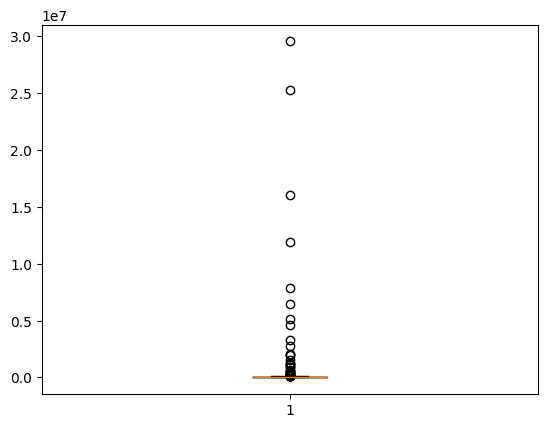

In [41]:
degree_values = [v for k, v in G.degree(weight='2013-Q4')]
fig = plt.figure();
plt.boxplot(degree_values)

In [42]:
Din = nx.in_degree_centrality(G)
Dout = nx.out_degree_centrality(G)
CC = nx.closeness_centrality(G.reverse())  #reverse edges to match networx convention
BC = nx.betweenness_centrality(G.to_undirected())
EC = nx.eigenvector_centrality(G.reverse())  #reverse edges to match networx convention

In [43]:
#For plotting, we combine all the centrality dictionaries into a dataframe
dictionary_list = []
for country in Din.keys():
    row = {'country':country,
          'in_degree_centrality':Din[country],
          'out_degree_centrality':Dout[country],
          'closeness_centrality':CC[country],
          'betweenness_centrality':BC[country],
          'eigenvector_centrality':EC[country]}
    dictionary_list.append(row)
df_centrality = pd.DataFrame(dictionary_list)

df_centrality.sort_values(by = ['out_degree_centrality'],ascending = False).head()

country  in_degree_centrality  out_degree_centrality  \
2      Switzerland              0.116822               0.948598   
3           France              0.121495               0.887850   
13  United Kingdom              0.116822               0.855140   
0        Australia              0.107477               0.817757   
4    United States              0.121495               0.813084   

    closeness_centrality  betweenness_centrality  eigenvector_centrality  
2               0.946903                0.156384                0.218025  
3               0.895397                0.112950                0.218025  
13              0.873469                0.099170                0.208945  
0               0.845850                0.111580                0.208945  
4               0.839216                0.084956                0.218025

C:\Users\gilan\AppData\Local\Temp\ipykernel_16404\3342247016.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)  #rotate axis tick labels 90 degrees
C:\Users\gilan\AppData\Local\Temp\ipykernel_16404\3342247016.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)  #rotate axis tick labels 90 degrees
C:\Users\gilan\AppData\Local\Temp\ipykernel_16404\3342247016.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)  #rotate axis tick labels 90 degrees
C:\Users\gilan\AppData\Local\Temp\ipykernel_16404\3342247016.py:13: UserWarning: set_ticklabels() should only be used with a fixed

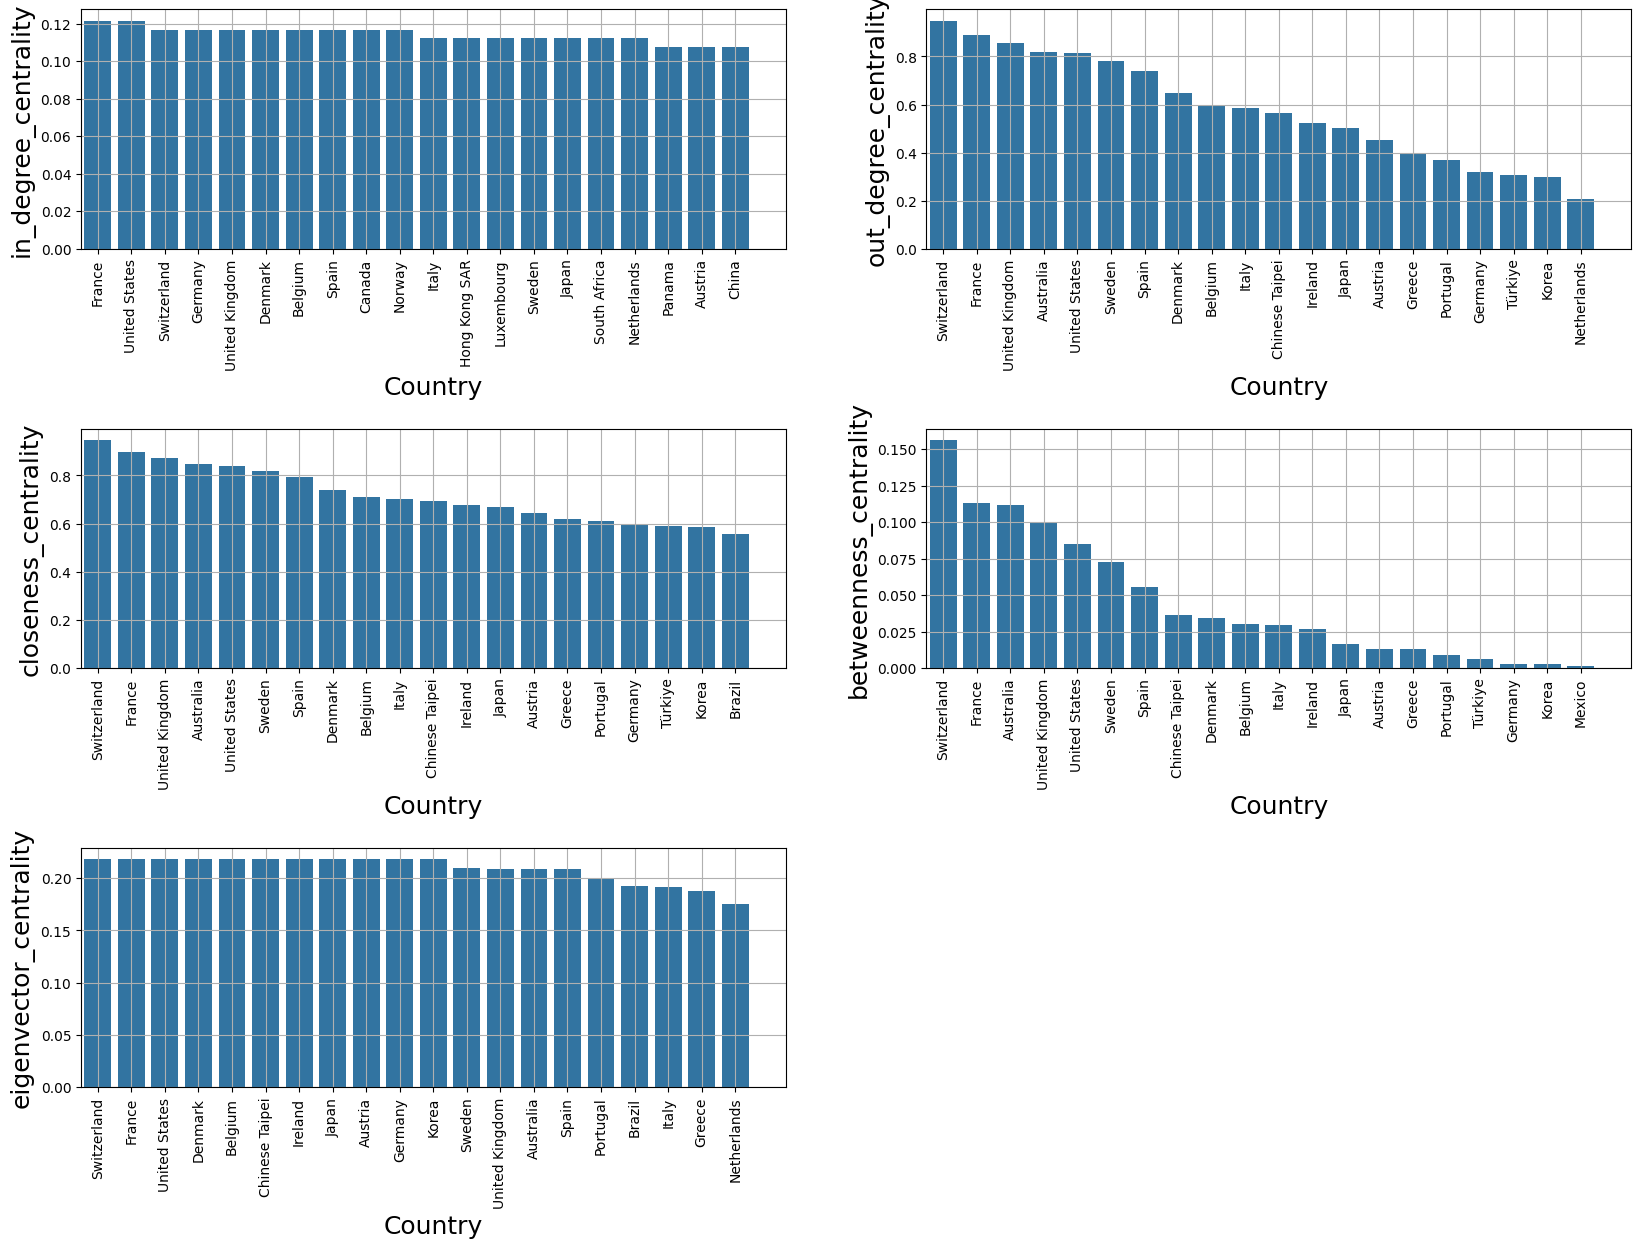

In [44]:
Centrality_names = df_centrality.columns.tolist()[1:]
kmax = 20  #show top kmax users


fig = plt.figure(figsize = (20,14))

for count,centrality_name in enumerate(Centrality_names):
    plt.subplot(3,2,count+1) #make a 2 x 3 subplot, plot in box cnt+1
    df_plot = df_centrality.sort_values(by=[centrality_name],ascending=False).head(n=kmax)  #sort dataframe by centrality value

    ax = sns.barplot(data=df_plot, x='country', y=centrality_name)
    plt.xlim([-.5,kmax+.5])  #set xlimits to only show top kmax users
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)  #rotate axis tick labels 90 degrees
    #plt.xticks(fontsize = 14)
    #plt.yticks(fontsize = 14)
    plt.ylabel(f"{centrality_name}",fontsize = 18)
    plt.xlabel('Country',fontsize = 18)
    plt.grid()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.75)

plt.show()

In [45]:
deg = dict(G.degree(weight='2013-Q4'))
deg = {k: v for k, v in sorted(deg.items(), key=lambda item: item[1], reverse=False)}

deg2 = dict(G2.degree(weight='2013-Q4'))
deg2 = {k: v for k, v in sorted(deg2.items(), key=lambda item: item[1], reverse=False)}
deg2

{'Panama': 93430.35500000001,
 'Greece': 117790.129,
 'Chile': 123148.378,
 'Portugal': 205633.2,
 'Türkiye': 220438.972,
 'Chinese Taipei': 262712.63899999997,
 'Austria': 289606.893,
 'Korea': 313989.528,
 'Mexico': 371630.92,
 'Brazil': 476873.78799999994,
 'Belgium': 477661.75800000003,
 'Denmark': 477829.009,
 'Ireland': 535960.972,
 'Sweden': 736121.696,
 'Australia': 759148.249,
 'Italy': 1144511.051,
 'Canada': 1232854.3969999999,
 'Netherlands': 1594188.0270000002,
 'Switzerland': 1735423.7969999998,
 'Spain': 1821684.346,
 'Japan': 2995991.211,
 'Germany': 3373919.6059999997,
 'France': 3382138.685,
 'United Kingdom': 5142528.721,
 'United States': 7510576.535}

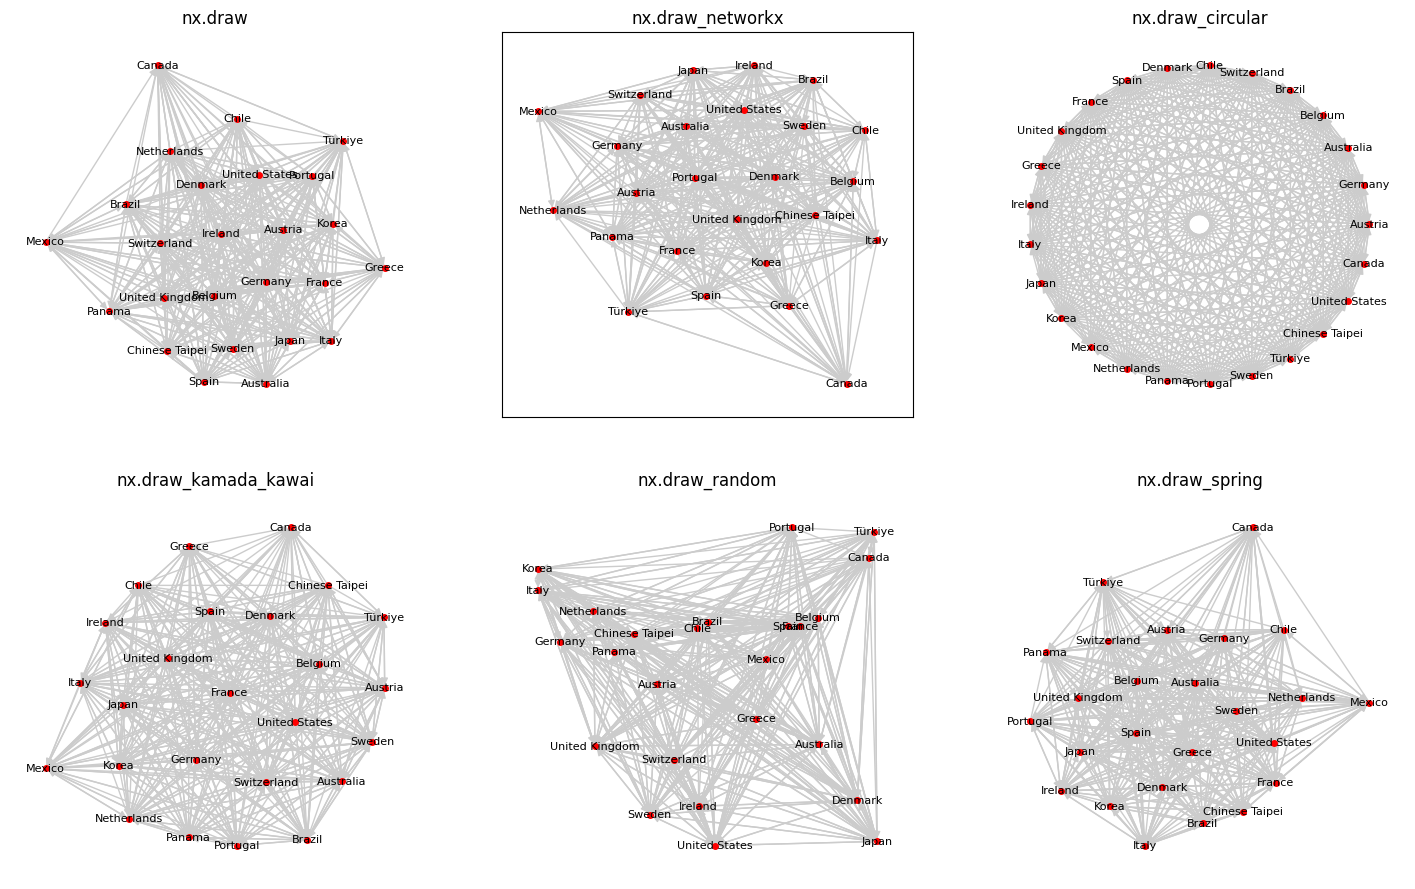

In [46]:
fig, axs = plt.subplots(2,3)
fig.set_figheight(11)
fig.set_figwidth(18)

axs[0,0].set_title('nx.draw')
nx.draw(G2, ax=axs[0,0], node_color="red", node_size=16, edge_color="#cccccc", width=1, font_size=8, with_labels=True)

axs[0,1].set_title('nx.draw_networkx')
nx.draw_networkx(G2, ax=axs[0,1], node_color="red", node_size=16, edge_color="#cccccc", width=1, font_size=8, with_labels=True)

axs[0,2].set_title('nx.draw_circular')
nx.draw_circular(G2, ax=axs[0,2], node_color="red", node_size=16, edge_color="#cccccc", width=1, font_size=8, with_labels=True)

axs[1,0].set_title('nx.draw_kamada_kawai')
nx.draw_kamada_kawai(G2, ax=axs[1,0], node_color="red", node_size=16, edge_color="#cccccc", width=1, font_size=8, with_labels=True)

axs[1,1].set_title('nx.draw_random')
nx.draw_random(G2, ax=axs[1,1], node_color="red", node_size=16, edge_color="#cccccc", width=1, font_size=8, with_labels=True)

axs[1,2].set_title('nx.draw_spring')
nx.draw_spring(G2, ax=axs[1,2], node_color="red", node_size=16, edge_color="#cccccc", width=1, font_size=8, with_labels=True)

In [47]:
deg2['United States']

7510576.535

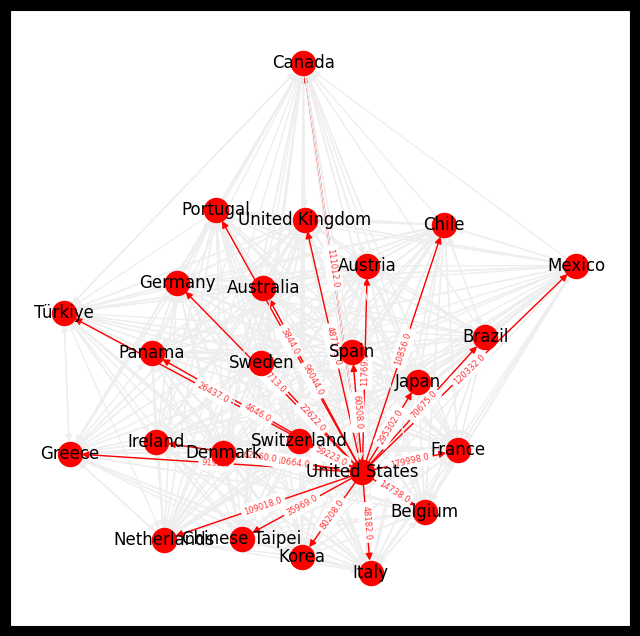

In [48]:
#Draw the network, with labels
edge_colors = ['red' if deg2[e[0]] > 7e6 else '#eeeeee' for e in G2.edges]
edge_labels = dict([((n1, n2), G2[n1][n2]['2013-Q4']) if deg2[n1] > 7e6 else ((n1, n2), "")
                    for n1, n2 in G2.edges])

# Draw
fig = plt.figure(figsize=(8,8))
pos = nx.spring_layout(G2)
nx.draw_networkx(G2, pos, node_color = 'red', width= 1,
        edge_color=edge_colors, with_labels=True,font_color = 'black')
nx.draw_networkx_edge_labels(G2, pos, edge_labels=edge_labels, alpha=0.8, font_size=6, font_color='red')
fig.set_facecolor('black')
plt.show()

In [49]:
# See: https://github.com/WestHealth/pyvis/issues/49#issuecomment-853087674
from IPython.display import display, HTML

net = Network(notebook=True,
            width="100%",
            height="600px",
            cdn_resources="in_line",
            neighborhood_highlight=False,
            select_menu=False,
           )

net.toggle_hide_edges_on_drag(False)
net.barnes_hut(gravity=-80000, central_gravity=0.3, spring_length=10, spring_strength=0.002, damping=0.09, overlap=0)
net.repulsion(2000)

# reuse plotly color palette
palette = px.colors.sequential.Plasma  # 7 colors
factor = len(deg2)/len(palette)

net.from_nx(G2)

for node in net.nodes:
    degree = G2.degree(weight='2013-Q4')[node['label']]
    node['size'] = degree/50000
    node['font'] = {"size": 100}
    node['color'] = palette[int(list(deg2).index(node['label'])/factor)]

for edge in net.edges:
    # get value from main Network weight
    edge['value'] = G2.edges[edge['from'], edge['to']]['2013-Q4']
    edge['font'] = {"size": 40}

net.show('network.html')
display(HTML('network.html'))

network.html


In [50]:
# See: https://github.com/WestHealth/pyvis/issues/49#issuecomment-853087674
from IPython.display import display, HTML

net = Network(notebook=True,
            width="100%",
            height="600px",
            cdn_resources="in_line",
            neighborhood_highlight=False,
            select_menu=False,
           )

net.toggle_hide_edges_on_drag(False)
net.barnes_hut(gravity=-80000, central_gravity=0.3, spring_length=10, spring_strength=0.002, damping=0.09, overlap=0)
net.repulsion(2000)

# reuse plotly color palette
palette = px.colors.sequential.Plasma  # 7 colors
factor = len(deg)/len(palette)

net.from_nx(G)

for node in net.nodes:
    degree = deg[node['label']]
    node['size'] = degree/50000
    node['font'] = {"size": 100}
    node['color'] = palette[int(list(deg).index(node['label'])/factor)]

for edge in net.edges:
    # get value from main Network weight
    edge['value'] = G.edges[edge['from'], edge['to']]['2013-Q4']
    edge['font'] = {"size": 40}

net.show("network.html")
display(HTML('network.html'))

network.html


C:\Users\gilan\AppData\Local\Temp\ipykernel_16404\1742835788.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


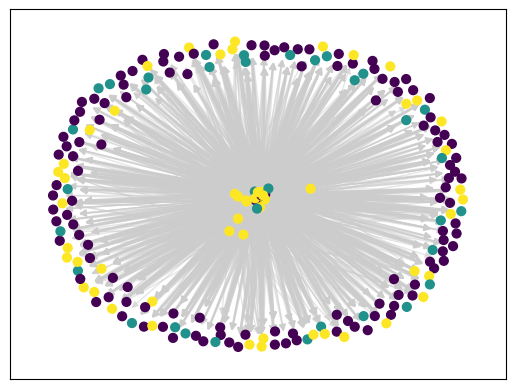

In [51]:
# compute the best partition
partition = community_louvain.best_partition(G.to_undirected())

# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5, width=1, edge_color="#cccccc")
plt.show()

In [52]:
df_part = pd.DataFrame(partition.items(), columns=['Country','Partition'])
num_parts = len(set(df_part['Partition']))
num_parts

3

In [53]:
for i in range(0, num_parts):
  print("Group %i" % i)
  display(", ".join(df_part[df_part['Partition']==i]['Country']))
  print("")

Group 0


"Australia, Chad, Switzerland, France, United States, Spain, United Kingdom, Sweden, Turks and Caicos Islands, Barbados, Uganda, Fiji, Venezuela, Estonia, North Korea, Sudan, Congo Democratic Republic, Central African Republic, Maldives, Solomon Islands, Seychelles, Malawi, Honduras, Mozambique, Togo, Burkina Faso, Bangladesh, Jamaica, Equatorial Guinea, Gibraltar, Zambia, Gambia, Dominica, Yemen, Syria, Guatemala, Rwanda, Zimbabwe, Nauru, Benin, Vatican City State, Sierra Leone, Mali, Sint Maarten, Comoros, Myanmar, Eritrea, San Marino, U.S. Miscellaneous Pacific Islands, Namibia, Kiribati, Belize, Congo, Paraguay, Serbia, Andorra, Falkland Islands, Vanuatu, Faeroe Islands, Tanzania, Ghana, Wallis and Futuna, Sri Lanka, Grenada, Trinidad and Tobago, Bonaire, Sint Eustatius and Saba, Angola, Suriname, Costa Rica, St. Lucia, Montenegro, Nicaragua, Madagascar, Guyana, Bolivia, Bhutan, Niger, Uruguay, Ethiopia, Somalia, Pakistan, Kenya, Uzbekistan, Guinea-Bissau, El Salvador, Papua New Gu


Group 1


'Belgium, Denmark, Italy, Türkiye, Egypt, Bosnia and Herzegovina, Jordan, Mauritius, Kuwait, Georgia, Lithuania, Liberia, Burundi, Belarus, Kazakhstan, Croatia, Slovenia, Iceland, Colombia, Curacao, Moldova, Tunisia, Tajikistan, Greenland, Albania, Marshall Islands, Senegal, Morocco, Lebanon, Bahrain, Residual West Indies UK, Unallocated location, Libya, Bulgaria, Azerbaijan, Liechtenstein'


Group 2


'Austria, Germany, Brazil, Chile, Finland, Greece, Ireland, Japan, Korea, Mexico, Netherlands, Panama, Portugal, Chinese Taipei, Saudi Arabia, Canada, Luxembourg, India, Malta, Hong Kong SAR, Malaysia, Guernsey, Qatar, United Arab Emirates, Israel, Latvia, Iran, Hungary, Czechia, Cayman Islands, Peru, St Helena, Ascension and Tristan da Cunha, Bermuda, Philippines, Tuvalu, New Zealand, Poland, Nigeria, Romania, Cuba, Sao Tome and Principe, Bahamas, Jersey, China, Indonesia, South Africa, Macao SAR, Norway, Slovakia, Singapore, Thailand, Russia, Cyprus, Isle of Man, Argentina'

In [54]:
for path in nx.all_simple_paths(G, 'United Kingdom', 'Central African Republic', cutoff=2):
    print(path)

['United Kingdom', 'Sweden', 'Central African Republic']
['United Kingdom', 'France', 'Central African Republic']
['United Kingdom', 'Australia', 'Central African Republic']
['United Kingdom', 'Switzerland', 'Central African Republic']


In [55]:
nx.shortest_path(G, 'United Kingdom', weight='2013-Q4')['Central African Republic']

['United Kingdom', 'Panama', 'Sweden', 'Central African Republic']

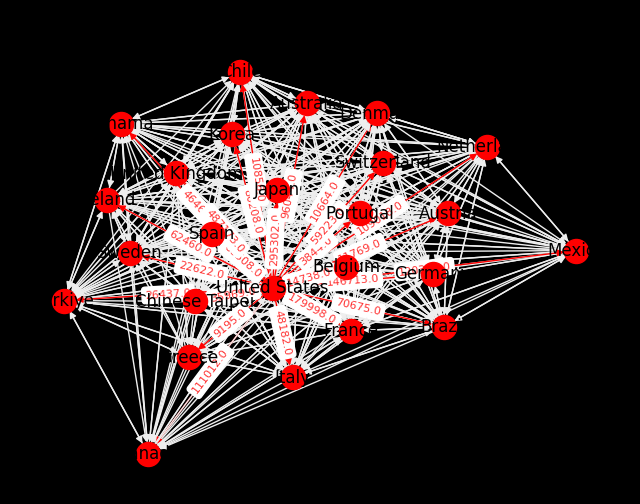

In [56]:
# set up the frames
frames = ['2013-Q4', '2014-Q4', '2015-Q4', '2016-Q4', '2017-Q4']
pos = nx.spring_layout(G2)

# Build plot
fig, ax = plt.subplots(figsize=(8,6))


def update(num):
    ax.clear()
    i = 1
    j = num

    deg_i = dict(G2.degree(weight=frames[num]))
    deg_i = {k: v for k, v in sorted(deg_i.items(), key=lambda item: item[1], reverse=False)}

    edge_colors = ['red' if deg_i[e[0]] > 7e6 else '#eeeeee' for e in G2.edges]
    edge_labels = dict([((n1, n2), G2[n1][n2][frames[num]]) if deg_i[n1] > 7e6 else ((n1, n2), "")
                    for n1, n2 in G2.edges])

    # Background nodes
    nx.draw(G2, pos, node_color = 'red', width= 1,
        edge_color=edge_colors, with_labels=True,font_color = 'black', ax=ax)
    nx.draw_networkx_edge_labels(G2, pos, edge_labels=edge_labels, alpha=0.8, font_size=8, font_color='red', ax=ax)
    fig.set_facecolor('black')

    # Scale plot ax
    ax.set_title("Frame %d:    "%(num+1) +  frames[num], fontweight="bold")
    ax.set_xticks([])
    ax.set_yticks([])


ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=1000, repeat=True)
HTML(ani.to_jshtml())